## Training


In [1]:
!pip install pycocotools

     |████████████████████████████████| 106 kB 4.6 MB/s eta 0:00:01
  Created wheel for pycocotools: filename=pycocotools-2.0.3-cp37-cp37m-linux_x86_64.whl size=273570 sha256=2f563a847a30670356d27d49bfd3b0b3ca7a8ed421fb60b732490ebf23f322e3
  Stored in directory: /root/.cache/pip/wheels/a2/09/4f/27f24df9927973a2dd820c3fb741c49d1208b25eb5331181c5
Successfully built pycocotools


In [2]:
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [ ]:
data_path=Path('../input/sartorius-cell-instance-segmentation')
annFile = Path('../input/sartorius-cell-instance-segmentation-coco/annotations_all.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds[-3:])

In [ ]:
data_path=Path('../input/sartorius-cell-instance-segmentation')
annFile = Path('../input/sartorius-cell-instance-segmentation-coco/annotations_all.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds[-3:])

In [7]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-n8h1mc40
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-n8h1mc40
  Resolved https://github.com/facebookresearch/detectron2.git to commit f14e6310116872a3dc02f8e52aa9069cf018501d
     |████████████████████████████████| 49 kB 2.7 MB/s eta 0:00:011
     |████████████████████████████████| 74 kB 2.4 MB/s  eta 0:00:01
     |████████████████████████████████| 145 kB 42.3 MB/s eta 0:00:01
     |████████████████████████████████| 130 kB 54.9 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 59.3 MB/s eta 0:00:01
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5706784 sha256=4f6403743e4f586e9bafc7b7c5e561ff2b763e8999a18dfaa5596b1e8719a873
  Stored in directory: /tmp/pip-ephem-wheel-cache-4jtq2ixx/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7d149d69c27ca5d
  Created wheel for fvcore: filename=fvcore-0.1

In [8]:
import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
setup_logger()

<_Logger detectron2 (DEBUG)>

### Load the competition data
This is very simple once we have our data in the COCO format. See the [part one notebook](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) for details.

In [9]:
data_path=Path('../input/sartorius-cell-instance-segmentation/')
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'
register_coco_instances('sartorius_train',{}, '../input/sartorius-cell-instance-segmentation-coco/annotations_train.json', data_path)
register_coco_instances('sartorius_val',{},'../input/sartorius-cell-instance-segmentation-coco/annotations_val.json', data_path)
metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')

[11/30 02:24:00 d2.data.datasets.coco]: Loading ../input/sartorius-cell-instance-segmentation-coco/annotations_train.json takes 2.07 seconds.
[11/30 02:24:00 d2.data.datasets.coco]: Loaded 485 images in COCO format from ../input/sartorius-cell-instance-segmentation-coco/annotations_train.json


### To check if data is loaded correctly

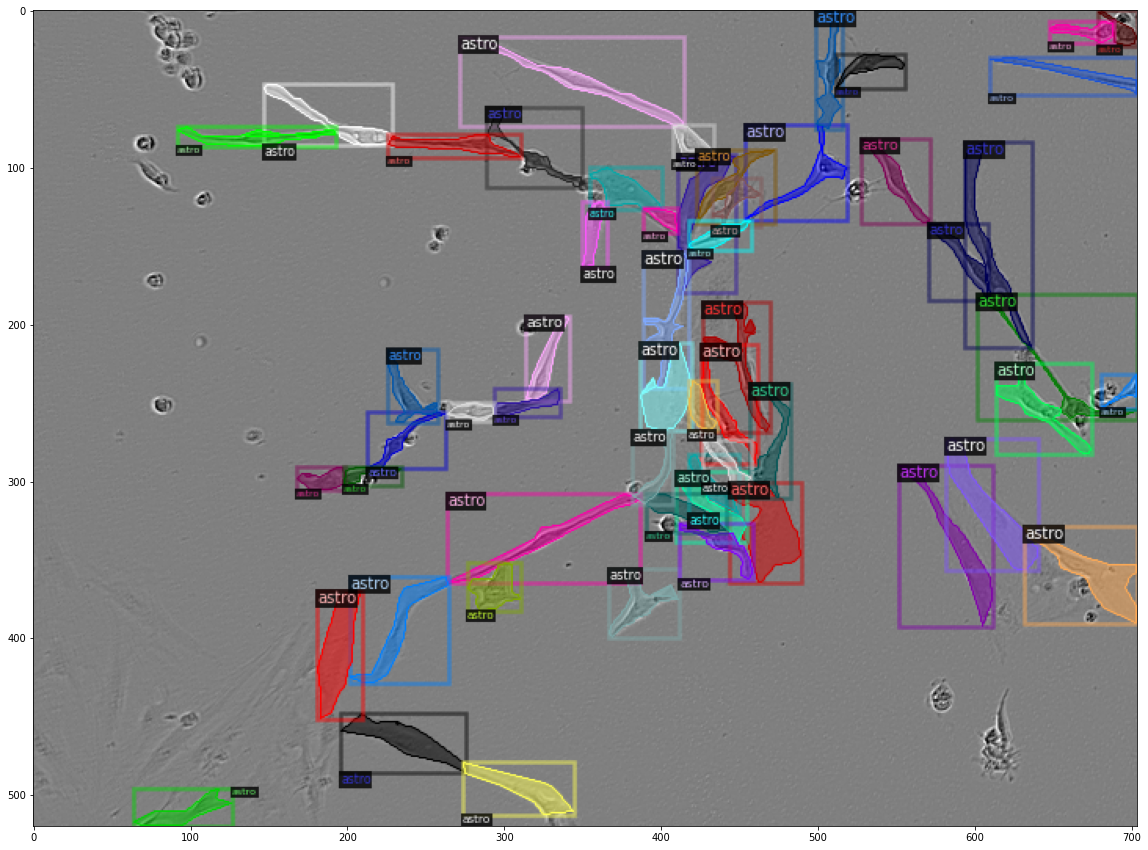

In [10]:
data_d = train_ds[42]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(data_d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

### Define evaluator 
There are some set of evaluaters we need to use for this project

In [11]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)
    

### Train

In [12]:
#assigning weights and loading model 
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sartorius_train",)
cfg.DATASETS.TEST = ("sartorius_val",)
cfg.DATALOADER.NUM_WORKERS = 2


cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0005 
cfg.SOLVER.MAX_ITER = 10000   
cfg.SOLVER.STEPS = []        


cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5
cfg.TEST.EVAL_PERIOD = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/30 02:24:04 d2.data.datasets.coco]: Loading ../input/sartorius-cell-instance-segmentation-coco/annotations_train.json takes 1.30 seconds.
[11/30 02:24:04 d2.data.datasets.coco]: Loaded 485 images in COCO format from ../input/sartorius-cell-instance-segmentation-coco/annotations_train.json
[11/30 02:24:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

model_final_f10217.pkl: 178MB [00:09, 18.8MB/s]                              


[11/30 02:24:28 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.7/site-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/opt/conda/lib/python3.7/site-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it 

[11/30 02:25:06 d2.utils.events]:  eta: 1:46:11  iter: 19  total_loss: 6.48  loss_cls: 1.317  loss_box_reg: 0.3607  loss_mask: 0.6947  loss_rpn_cls: 3.751  loss_rpn_loc: 0.3506  time: 1.6987  data_time: 1.1569  lr: 9.9905e-06  max_mem: 5108M
[11/30 02:25:37 d2.utils.events]:  eta: 1:59:34  iter: 39  total_loss: 3.122  loss_cls: 1.228  loss_box_reg: 0.3466  loss_mask: 0.6921  loss_rpn_cls: 0.4764  loss_rpn_loc: 0.3009  time: 1.6336  data_time: 1.1406  lr: 1.998e-05  max_mem: 5108M
[11/30 02:26:14 d2.utils.events]:  eta: 1:59:20  iter: 59  total_loss: 2.759  loss_cls: 1.022  loss_box_reg: 0.3616  loss_mask: 0.6874  loss_rpn_cls: 0.3689  loss_rpn_loc: 0.3261  time: 1.7062  data_time: 1.4132  lr: 2.997e-05  max_mem: 5357M
[11/30 02:26:45 d2.utils.events]:  eta: 2:09:14  iter: 79  total_loss: 2.575  loss_cls: 0.8379  loss_box_reg: 0.4588  loss_mask: 0.6792  loss_rpn_cls: 0.3297  loss_rpn_loc: 0.2968  time: 1.6657  data_time: 1.1286  lr: 3.9961e-05  max_mem: 5357M
[11/30 02:27:03 d2.utils.ev